Classification models can be 'calibrated', but this term is used to refer to several related but subtly different concepts.

Here's a classification model.

$x \in \mathcal{X}$ is a feature fector

$y \in \{0, 1\}$ is a binary label

Our objective is infer $y$ from $x$ for unseen samples. We train a model $f: \mathcal{X} \rightarrow \mathbb{R}$ which outputs a scalar where larger values indicate a greater likelihood of $y$ being $1$.

We train our model on a data set $x^{(n)}, y^{(n)} \sim p(x) p(y | x)$. For each sample $s^{(n)} = f(x^{(n)})$.

Models come in two flavours:
*   Probabilistic models, where $f:\mathcal{X}\rightarrow[0,1]$, such that the output of our model can be interpreted as the probability that the label is a $1$. Like a logistic regression.
*   Non-probabilistic models, where the model output cannot be interpreted as a probability. Like an SVM.

Everything here applies only to probabilistic models.

Sloppy limits throughout, all as the number of samples $N \rightarrow \infty$.

## "Strong" Calibration

A model is strongly calibrated if $f(x) \rightarrow p(y|x)$. Thus, the model prediction is a consistent prediction of the label for any input value.

Practically, we could test for strong calibration by partitioning $X$ and comparing the proportion of positive labels in each partition with the model prediction. This is fine for small numbers of dimensions, like maybe 3. More than that and there will be hardly any samples in most partitions because of the curse of dimensionality. This motivates taking a look at...

## "Weak" Calibration

Consider an interval $[t, t+d]$, where $t \geq 0$ and $t + d \leq 1$, and its preimage $A = \{x : t < f(x) < t + d\}$. A model is weakly calibrated if

$\int_A f(x) p(x) dx \rightarrow \int_A p(y|x) p(x) dx$ for all intervals $[t, t+d]$.

We can see that this is a weaker condition because it only relates $p(y|x)$ to $f(x)$ in a projection, rather than all dimensions. It is useful because it leads to a practical check.

On the right hand side, by Monte Carlo theorem:

$\int_A p(y|x) p(x) dx \approx \frac{1}{N}\sum \mathbb{1}(y^{(n)} = 1 \text{ and } x^{(n)} \in A) = \frac{1}{N}\sum \mathbb{1}(y^{(n)} = 1 \text{ and } f(x^{(n)}) \in [t, t+d])$

On the left hand side, if we consider a small interval, such that $f(x) \approx t$ throughout, and then use Monte Carlo:

$\int_A f(x) p(x) dx \approx t \int_A p(x) dx \approx \frac{t}{N} \sum \mathbb{1}(x^{(n)} \in A) = \frac{t}{N} \sum \mathbb{1}(f(x^{(n)}) \in [t, t+d])$

where $\mathbb{1}(\cdot)$ is $1$ if the condition is true and $0$ otherwise, and the sums are over all samples for which $f(x^{(n)}$ fall within $[t, t+d]$.

Putting the two halves together, this give us:

$t \approx \frac{\text{# positive samples in }[t, t+d]}{\text{# samples in }[t, t+d]}$

We can easily check this emperically.

## Linear calibration

A model is linearly calibrated if $\mathbb{E}[(y-s)] = 0$ (i.e. the average prediction is equal to the average label) and $\mathbb{E}[x_i(y-s)] = 0$ (i.e. every feature is uncorrelated with the prediction error.

## Relationships

Trivially, strong calibration implies weak calibration and linear calibration. But linear calibration does not imply weak calibration and vice versa. (See counter-examples below.)

## Calibration properties of specific models

Logistic regression trained with maximum likelihood is linearly calibrated. This can be seen because the conditions for linear calibration are the asymptotic limit of the K.K.T. conditions. See e.g. [this](https://stats.stackexchange.com/a/409756).

If the true generative process is also a logistic regression, then the model will be strongly calibrated, since the ML estimate is a consistent estimator of the true parameter values.

Applying Platt calibration to a non-calibrated output is not the same a training a logistic regression from scratch. With a full LR, the prediction is uncorrelated with every feature, whereas Platt calibration only ensure independence between prediction error and the intermediate output.

Isotonic regression is specifically designed to achieve weak calibration.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

## Linearly calibrated but not weakly calibrated

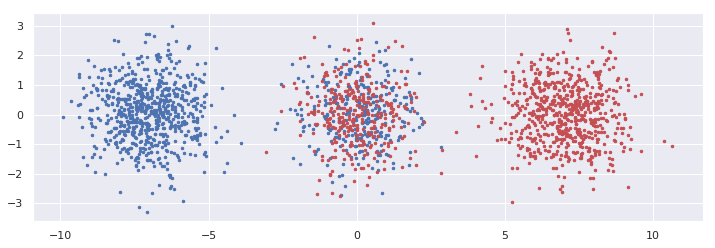

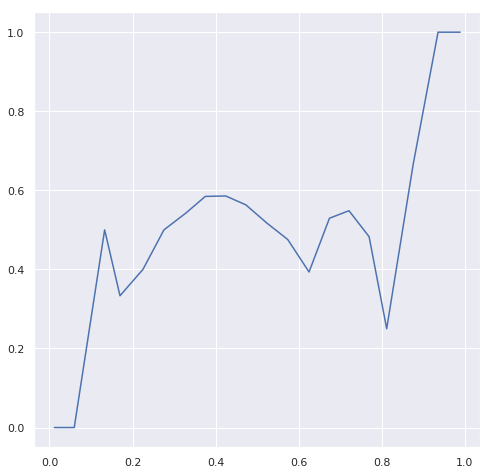

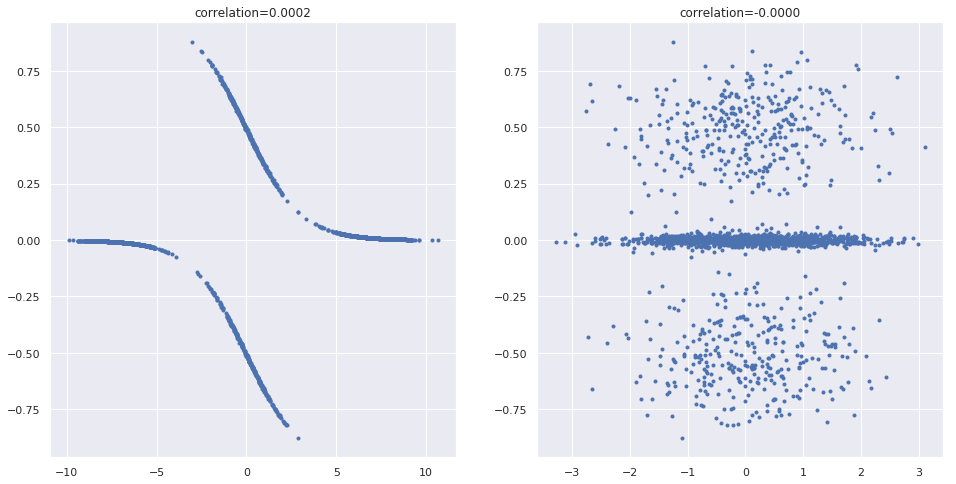

In [ ]:
# Make some data
def sample_data(N=2000):
  X = np.zeros((N, 2))
  y = np.zeros((N))
  for n in range(N):
    cluster = np.random.randint(-1, 2)
    X[n, :] = np.array([7*cluster, 0]) + np.random.randn(2)
    if cluster == -1:
      y[n] = 0
    elif cluster == 1:
      y[n] = 1
    else:
      y[n] = np.random.randint(2)
    
  return X,y

X,y = sample_data()

# Plot it
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(X[y==0,0], X[y==0,1], '.b', markersize=5)
ax.plot(X[y==1,0], X[y==1,1], '.r', markersize=5)
ax.set_aspect('equal')
plt.show()

# Train a model
lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)
s = lr.predict_proba(X)[:,1]
e = y - s

# Calibration - not weakly calibrated
prob_true, prob_pred = calibration_curve(y, s, n_bins=20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(prob_pred, prob_true)
plt.show()

# Calibration - is linearly calibrated
fig, axs = plt.subplots(figsize=(16,8), ncols=2)
for d in range(2):
  axs[d].plot(X[:,d], e, '.')
  axs[d].set_title(f'correlation={np.corrcoef(X[:,d], e)[1,0]:.4f}')
plt.show()

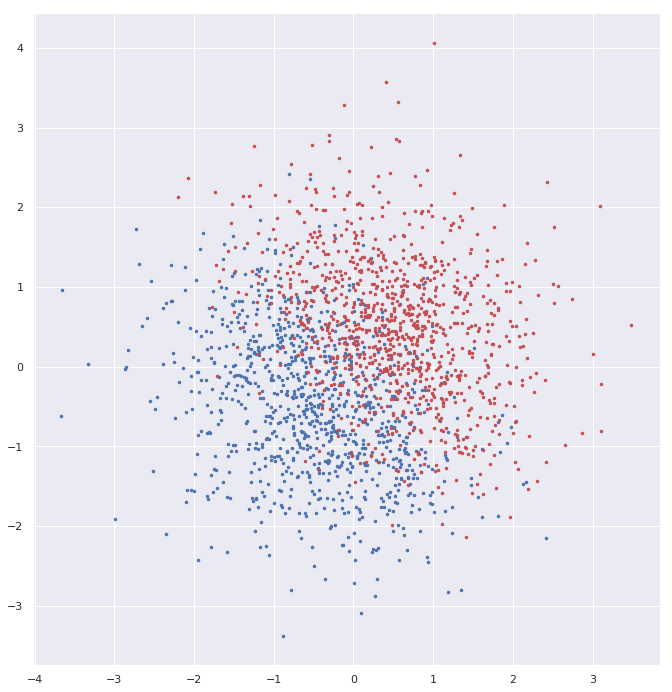

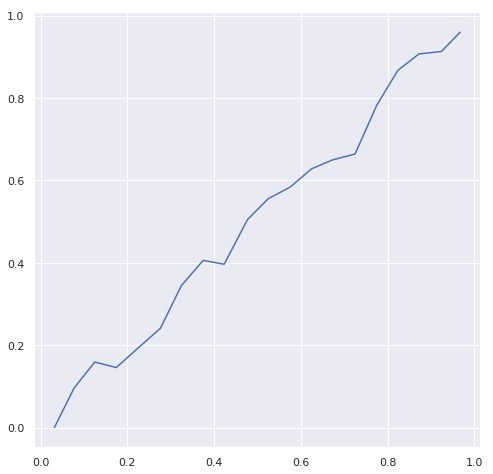

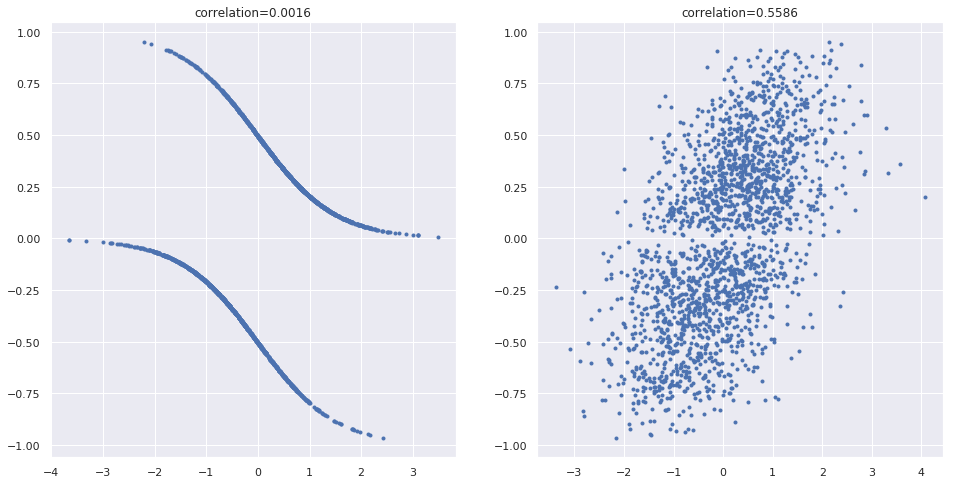

In [ ]:
# Make some data
def sample_data(N=2000):
  X = np.zeros((N, 2))
  y = np.zeros((N))
  for n in range(N):
    x = np.random.randn(2)
    X[n, :] = x
    sx = np.sum(x)
    p = expit(2 * sx)
    y[n] = np.random.rand() < p

  return X,y

X,y = sample_data()

# Plot it
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(X[y==0,0], X[y==0,1], '.b', markersize=5)
ax.plot(X[y==1,0], X[y==1,1], '.r', markersize=5)
ax.set_aspect('equal')
plt.show()

# Train a model - only use one feature
lr = LogisticRegression(solver='lbfgs')
lr.fit(X[:,0:1],y)
s = lr.predict_proba(X[:,0:1])[:,1]
e = y - s

# Calibration - is weakly calibrated
prob_true, prob_pred = calibration_curve(y, s, n_bins=20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(prob_pred, prob_true)
plt.show()

# Calibration - not linearly calibrated
fig, axs = plt.subplots(figsize=(16,8), ncols=2)
for d in range(2):
  axs[d].plot(X[:,d], e, '.')
  axs[d].set_title(f'correlation={np.corrcoef(X[:,d], e)[1,0]:.4f}')
plt.show()